In [1]:
from transformers import AutoTokenizer, AutoConfig
from ebany_research.llm_lora.changed_mistral import MistralForCausalLM
from datasets import load_dataset
import torch


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model_name = "Open-Orca/Mistral-7B-OpenOrca"
config = AutoConfig.from_pretrained(model_name)
device = 3
model = MistralForCausalLM.from_pretrained(model_name, device_map={"": device})
model = model.eval()
# 29410MiB
model = model.half()
print(count_parameters(model))
# model = MistralForCausalLM.from_pretrained(
#     model_name,
# )
# model = MistralForCausalLM._from_config(config=config)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
dataset = load_dataset("openaccess-ai-collective/oo-gpt4-filtered")
dataset = dataset["train"].to_list()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.14s/it]


7241748480


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/user-name-goes-here/.local/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
dataset[0].keys()

dict_keys(['id', 'system_prompt', 'question', 'response', '__index_level_0__'])

In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding, DataCollatorForLanguageModeling


class OpenOrcaDataset(Dataset):
    def __init__(
        self,
        dataset=None,
        tokenizer=None,
    ):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        dataset_item = self.dataset[idx]
        chat = [
            {"role": "system", "content": dataset_item["system_prompt"]},
            {"role": "user", "content": dataset_item["question"]},
            {"role": "assistant", "content": dataset_item["response"]},
        ]
        inputs = self.tokenizer.apply_chat_template(
            chat,
            tokenize=False,
            add_generation_prompt=True,
        )
        inputs = self.tokenizer(
            inputs,
            return_tensors="pt",
        )
        for key in inputs.keys():
            inputs[key] = inputs[key].squeeze(0)
        # print(inputs['input_ids'].shape)
        return inputs


train_elements = 1000
valid_elements = 100

train_dataset = OpenOrcaDataset(
    dataset=dataset[:train_elements],
    tokenizer=tokenizer,
)

valid_dataset = OpenOrcaDataset(
    dataset=dataset[train_elements : train_elements + valid_elements],
    tokenizer=tokenizer,
)

pad_datacollator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    # padding=True,
    mlm=False,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    collate_fn=pad_datacollator,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=2,
    collate_fn=pad_datacollator,
)

next(iter(train_dataloader))
next(iter(valid_dataloader))
# train_dataset[0]

{'input_ids': tensor([[    1, 32001,  1587,    13,  1976,   460,   396, 16107, 13892, 28723,
           995,   622,   347,  2078,   264,  3638, 28723,   995,  1580,  8270,
           264, 10537,   304,  1043,  4372, 28723, 32000, 32001,  2188,    13,
            13,    13, 28798,   556,   276,  1987, 11285, 28742, 28713,  3487,
         20415,   298,  1912,   706,   684,   272,  6400,   354,   272,  8982,
          4150, 28723, 28705, 12628,   272,  2996,   345, 11273,   400,  1987,
           767,   863, 14151,   927,   298,   511, 28804,   548,   349,   345,
         10847,   264,  4150, 28739,   264,  3716,  4372, 28804,    13,  2820,
         16981, 28747, 32000, 32001, 13892,    13,  2501, 28725,   345, 10847,
           264,  4150, 28739,   349,   459,   264,  3716,  4372,   298,   272,
          2996,   345, 11273,   400,  1987,   767,   863, 14151,   927,   298,
           511,  1110, 28723,   415,  2996, 21165,   356,   767, 14151,  3236,
           298,   511,  1159,  2492,  

### student model

In [3]:
device = 2
student_model = MistralForCausalLM.from_pretrained(model_name, device_map={"": device})
student_model = student_model.eval()
student_model = student_model.half()

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


In [4]:
distill_layer = 17
student_mlp = student_model.model.layers[distill_layer].mlp

student_gate_proj = student_mlp.gate_proj.weight.data
student_up_proj = student_mlp.up_proj.weight.data
student_down_proj = student_mlp.down_proj.weight.data

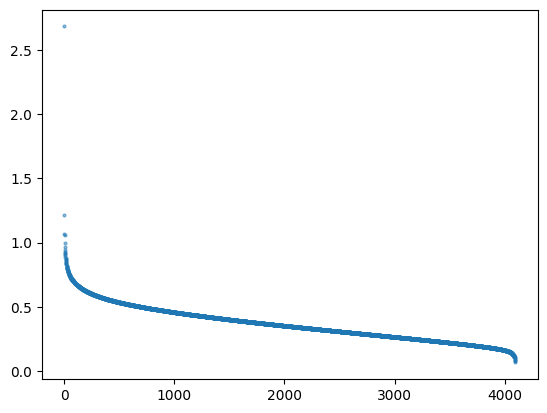

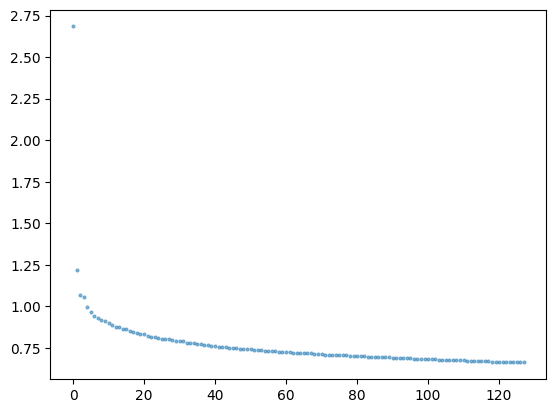

In [5]:
import matplotlib.pyplot as plt
import numpy as np

U, S, Vh = torch.linalg.svd(
    student_gate_proj.to(torch.float32),
    # student_up_proj.to(torch.float32),
    # student_down_proj.to(torch.float32),
    # student_model.model.embed_tokens.weight.data.to(torch.float32),
    full_matrices=False,
)


area = 4

plt.scatter(
    torch.arange(0, S.shape[0]).numpy(),
    S.cpu().numpy(),
    s=area,
    alpha=0.5,
)
plt.show()

threshold = 128
plt.scatter(
    torch.arange(0, threshold).numpy(),
    S[:threshold].cpu().numpy(),
    s=area,
    alpha=0.5,
)
plt.show()

в целом можно заметить что самые основные значения лежат на первых 8-16

In [68]:
student_model.model.embed_tokens.weight.data.shape

torch.Size([32002, 4096])

In [69]:
32002 * 4096

131080192

### Replace to lora

In [6]:
(U @ torch.diag(S) @ Vh).shape

torch.Size([14336, 4096])

In [6]:
# from ebany_research.llm_lora.changed_neox import LinearLora
def get_L_R(weights=None, rank=64):
    U, S, Vh = torch.linalg.svd(
        weights.to(torch.float32),
        full_matrices=False,
    )

    U = U[:, :rank]
    S = torch.diag(S[:rank])
    Vh = Vh[:rank, :]

    L = U @ S
    R = Vh
    return L, R


L, R = get_L_R(student_down_proj)
print(L.shape, R.shape)


class LinearLora(torch.nn.Module):
    def __init__(self, in_dim=768, out_dim=768, r=16, bias=False):
        super().__init__()
        self.L = torch.nn.Linear(in_dim, r, bias=bias)
        self.R = torch.nn.Linear(r, out_dim, bias=bias)

    def forward(self, hidden_states):
        hidden_states = self.R(hidden_states)
        hidden_states = self.L(hidden_states)
        return hidden_states


def assign_new_weights(original_module, original_weights):
    L, R = get_L_R(original_weights, rank=16)
    original_module.L.weight.data = L
    original_module.R.weight.data = R


lora_gate_proj = LinearLora(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    bias=False,
)
lora_up_proj = LinearLora(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    bias=False,
)
lora_down_proj = LinearLora(
    in_dim=config.intermediate_size,
    out_dim=config.hidden_size,
    bias=False,
)

assign_new_weights(
    original_module=lora_gate_proj,
    original_weights=student_gate_proj,
)
assign_new_weights(
    original_module=lora_up_proj,
    original_weights=student_up_proj,
)
assign_new_weights(
    original_module=lora_down_proj,
    original_weights=student_down_proj,
)

student_mlp.gate_proj = lora_gate_proj
student_mlp.up_proj = lora_up_proj
student_mlp.down_proj = lora_down_proj

torch.Size([4096, 64]) torch.Size([64, 14336])


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(count_parameters(model))
print(count_parameters(student_model))

7241748480
7066472448


### eval original model

In [7]:
import tqdm


def eval_model(model):
    total_eval_loss = 0
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            for eval_batch in tqdm.tqdm(valid_dataloader):
                # print(eval_batch)

                for key in eval_batch.keys():
                    eval_batch[key] = eval_batch[key].to(model.device)

                loss = model(
                    **eval_batch,
                )
                total_eval_loss += loss.loss.item()
    # break
    total_eval_loss = total_eval_loss / len(valid_dataloader)
    return total_eval_loss


teacher_loss = eval_model(model)
print(teacher_loss)
print(torch.exp(torch.tensor(teacher_loss)))

100%|██████████| 50/50 [00:09<00:00,  5.49it/s]

2.3748738026618956
tensor(10.7497)


In [8]:
student_model = student_model.eval()

student_loss = eval_model(student_model)
print(student_loss)
print(torch.exp(torch.tensor(student_loss)))

100%|██████████| 50/50 [00:08<00:00,  5.75it/s]

2.3757719230651855
tensor(10.7593)


In [9]:
import gc

# model = model.cpu()
gc.collect()
torch.cuda.empty_cache()

### callibrate lora

In [10]:
import tqdm


def train_model(model):
    for param in model.named_parameters():
        if "L" in param[0] or "R" in param[0]:
            print(param[0])
            param[1].requires_grad_(True)
        else:
            param[1].requires_grad_(False)

    total_train_loss = 0
    # model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
    accum_iter = 4
    with torch.autocast(device_type="cuda"):
        for batch_id, train_batch in tqdm.tqdm(enumerate(train_dataloader)):
            # print(eval_batch)

            for key in train_batch.keys():
                train_batch[key] = train_batch[key].to(model.device)

            loss = model(
                **train_batch,
            )
            loss = loss.loss / accum_iter
            # loss = loss.loss

            loss.backward()
            total_train_loss += loss.item()

            if (batch_id + 1) % accum_iter or (batch_id + 1 == len(train_dataloader)):
                # print(loss.item())
                optimizer.step()
                optimizer.zero_grad()
                break
            # if (batch_id + 1) % accum_iter or (batch_id + 1 == len(train_dataloader)):
            # optimizer.step()
            # optimizer.zero_grad()
        # break
    total_train_loss = total_train_loss / len(train_dataloader)
    return total_train_loss


train_model(model=student_model)

model.layers.17.mlp.gate_proj.L.weight
model.layers.17.mlp.gate_proj.R.weight
model.layers.17.mlp.up_proj.L.weight
model.layers.17.mlp.up_proj.R.weight
model.layers.17.mlp.down_proj.L.weight
model.layers.17.mlp.down_proj.R.weight


165it [00:33,  4.90it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.38 GiB. GPU 2 has a total capacty of 39.39 GiB of which 1.93 GiB is free. Process 2465559 has 37.45 GiB memory in use. Of the allocated memory 36.33 GiB is allocated by PyTorch, and 598.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
student_model = student_model.eval()

student_loss = eval_model(student_model)
print(student_loss)
print(torch.exp(torch.tensor(student_loss)))

100%|██████████| 50/50 [00:04<00:00, 10.10it/s]

2.466512999534607
tensor(11.7813)
